# CutMix, MixUp, and RandAugment image augmentation with KerasCV

## Imports & setup


In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/MyDrive/[2024-2025]AN2DL/Homework1



Mounted at /gdrive
/gdrive/MyDrive/[2024-2025]AN2DL/Homework1


In [2]:
%%capture
!pip install keras_cv
import keras_cv

We begin by importing all required packages:

In [3]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import matplotlib.pyplot as plt


# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
import keras as tfk
from keras.layers import Input, Dense, Dropout, Lambda, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from keras import layers as tfkl
import keras_cv

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Tensorflow version -> 2.17.1
Keras version -> 3.5.0


## Data loading


In [4]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()

import numpy as np


data = np.load(
        'cleaned_data_dedup.npz'
)
X = data['images']
y = data['labels']


# data, dataset_info = tfds.load("oxford_flowers102", with_info=True, as_supervised=True)
# train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
# val_steps_per_epoch = dataset_info.splits["test"].num_examples // BATCH_SIZE

In [7]:
class_mapping = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet"
}

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=seed, stratify=y)

class_names =  list(class_mapping.values())
data_train = tf.data.Dataset.from_tensor_slices((X_train, y_train.flatten())).batch(BATCH_SIZE, drop_remainder=True)
data_val = tf.data.Dataset.from_tensor_slices((X_val, y_val.flatten())).batch(BATCH_SIZE, drop_remainder=True)

print(data_val)

<_BatchDataset element_spec=(TensorSpec(shape=(32, 96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(32,), dtype=tf.uint8, name=None))>


In [8]:
IMAGE_SIZE = (96, 96)
num_classes = 8


def to_dict(image, label):
    #image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, num_classes)

    return {"images": image, "labels": label}


def prepare_dataset(dataset, split):
    if split == "train":
        return (
            dataset.shuffle(10 * BATCH_SIZE)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
        )
    else:
        return dataset.map(to_dict, num_parallel_calls=AUTOTUNE)


def load_dataset(split="train"):
    if split == "train":
      dataset = data_train
    elif split == "val":
      dataset = data_val

    else:
      dataset = data_test
    return prepare_dataset(dataset, split)


train_dataset = load_dataset()

Let's inspect some samples from our dataset:

(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)


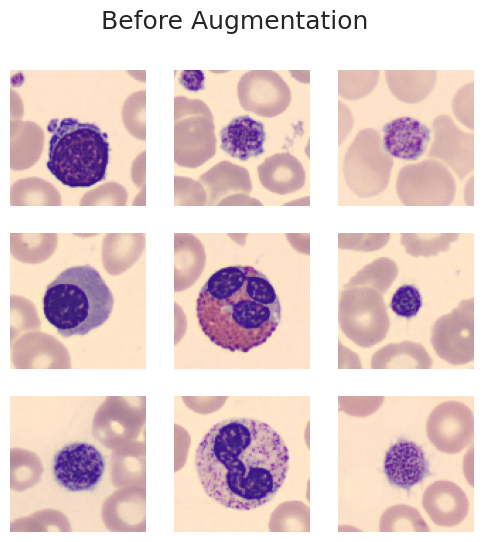

In [9]:

def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        print(images.shape)
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()


visualize_dataset(train_dataset, title="Before Augmentation")

## RandAugment

[RandAugment](https://arxiv.org/abs/1909.13719)


In [10]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=1.0,
)


def apply_rand_augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs


train_dataset = load_dataset().map(apply_rand_augment, num_parallel_calls=AUTOTUNE)

(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)


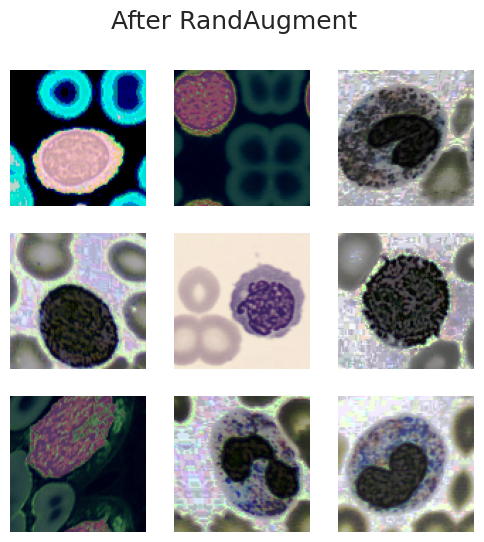

In [11]:
visualize_dataset(train_dataset, title="After RandAugment")

## CutMix and MixUp: generate high-quality inter-class examples

- [CutMix: Train Strong Classifiers](https://arxiv.org/abs/1905.04899)
- [MixUp: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)


(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)


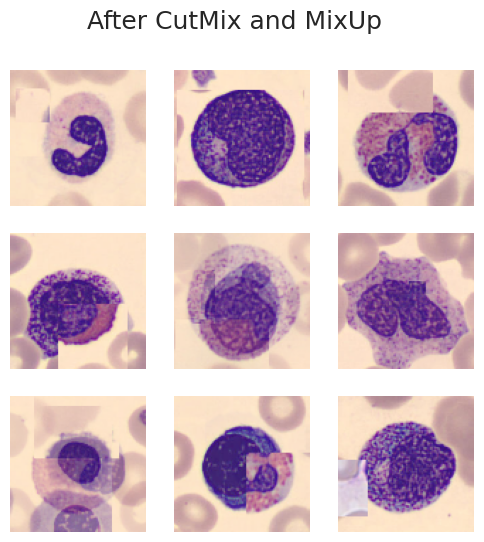

In [12]:
cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()


def cut_mix_and_mix_up(samples):
    samples = cut_mix(samples, training=True)
    samples = mix_up(samples, training=True)
    return samples


train_dataset = load_dataset().map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)

visualize_dataset(train_dataset, title="After CutMix and MixUp")

## Training a CNN

(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)


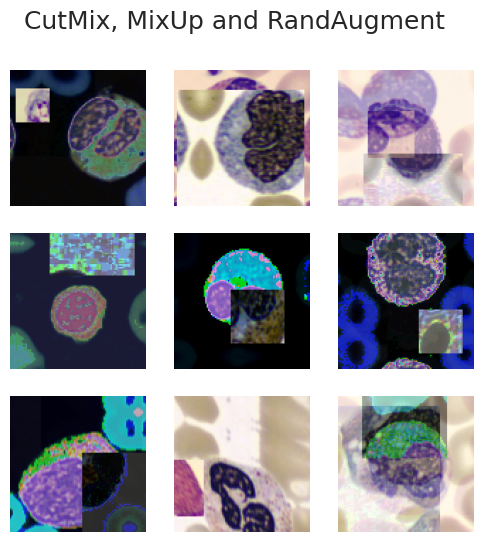

In [13]:

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels


train_dataset = (
    load_dataset()
    .map(apply_rand_augment, num_parallel_calls=AUTOTUNE)
    .map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)
)

visualize_dataset(train_dataset, "CutMix, MixUp and RandAugment")

train_dataset = train_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

val_dataset = load_dataset(split="val")
val_dataset = val_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)


Finally we train the model:

In [16]:
def fine_fine_tune_effNet():
    ft_model = tfk.models.load_model('Fine_Fine_tuneEfficientNet_98.78.keras')

    ft_model.get_layer('efficientnetb7').trainable = True

    # Set all MobileNetV3Small layers as non-trainable
    for layer in ft_model.get_layer('efficientnetb7').layers:
        layer.trainable = False

    # Enable training only for Conv2D and DepthwiseConv2D layers
    for i, layer in enumerate(ft_model.get_layer('efficientnetb7').layers):
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
            layer.trainable = True
            #print(i, layer.name, type(layer).__name__, layer.trainable)

    N_freeze = 500

    for layer in ft_model.get_layer('efficientnetb7').layers[:N_freeze]:
        layer.trainable = False
        #print(layer.name, layer.trainable)

    ft_model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.RMSprop(learning_rate = 1e-4),
        metrics=['accuracy']
    )

    return ft_model


In [17]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=4, factor=0.5, min_lr=1e-6)
]

model = fine_fine_tune_effNet()
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,

).history

final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

file_name = "Final" +  model.name + "_" + str(final_val_accuracy) + '.keras'

model.save(file_name)

Epoch 1/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 134s 169ms/step - accuracy: 0.7550 - loss: 1.1109 - val_accuracy: 0.9757 - val_loss: 0.1203 - learning_rate: 1.0000e-04
Epoch 2/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 46s 129ms/step - accuracy: 0.7515 - loss: 1.1131 - val_accuracy: 0.9774 - val_loss: 0.1069 - learning_rate: 1.0000e-04
Epoch 3/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 46s 129ms/step - accuracy: 0.7479 - loss: 1.1305 - val_accuracy: 0.9722 - val_loss: 0.1224 - learning_rate: 1.0000e-04
Epoch 4/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 46s 128ms/step - accuracy: 0.7513 - loss: 1.1081 - val_accuracy: 0.9722 - val_loss: 0.1503 - learning_rate: 1.0000e-04
Epoch 5/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 46s 128ms/step - accuracy: 0.7571 - loss: 1.1077 - val_accuracy: 0.9583 - val_loss: 0.1489 - learning_rate: 1.0000e-04
Epoch 6/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 46s 128ms/step - accuracy: 0.7441 - loss: 1.1160 - val_accuracy: 0.9549 - val_loss: 0.1419 - learning_rate: 1.0000e-04
Epoch 7/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 46s 1

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()